In [1]:
from numpy import pi
import numpy as np

from qiskit.opflow import I, Z, Zero, TensoredOp, PauliSumOp, PauliOp, \
                        PauliTrotterEvolution, Gradient, \
                        StateFn, CircuitStateFn, CircuitSampler
from qiskit.quantum_info import Operator, Pauli, PauliTable, SparsePauliOp

from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter

from qiskit.utils.quantum_instance import QuantumInstance



qasm_sim  = Aer.get_backend('qasm_simulator')
state_sim = Aer.get_backend('statevector_simulator')

### Hamiltonian
Alternative to generate a XX, YY, ZZ hamiltonian plus a tranverse field. 

It's faster for large number of spins (nor that it matters though).

In [2]:
periodic = False

# number of spins
n = 2
nt = n if periodic else n - 1

# neighbor interactions
mat = np.zeros((nt, n))
np.fill_diagonal(mat, 1)
np.fill_diagonal(mat[:, 1:], 1)

if periodic:
    mat[nt - 1, 0] = 1
    
# All interactions
data = np.zeros((3 * nt, 2 * n))
# XX interactions
data[:nt, :n] = mat

# YY interactions
data[nt:2 * nt, :n] = mat
data[nt:2 * nt, n:] = mat

# ZZ interactions
data[2 * nt:, n:] = mat

(Jx, Jy, Jz) = (1, 0.5, 0.25)
J = np.array([Jx, Jy, Jz])
coefs = np.repeat(J, nt)

pt = PauliTable(data)
interaction = SparsePauliOp(pt, coefs)

# Tranverse field
h = .1
data = np.zeros((n, 2 * n))
np.fill_diagonal(data[:, n:], 1)

coefs = h * np.ones(n)

pt = PauliTable(data)
tranverse = SparsePauliOp(pt, coefs)

ham = interaction + tranverse
ham._table.to_labels()

['XX', 'YY', 'ZZ', 'IZ', 'ZI']

### Trotterized

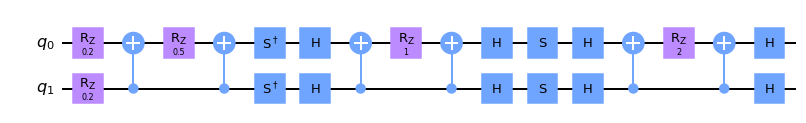

In [3]:
ham_op = PauliSumOp(ham)
evop = PauliTrotterEvolution().convert(ham_op.exp_i())

evop.primitive.draw('mpl')

###  Hilbert - Schmidt Test

Let's look at a toy example.

Target unitary:

In [4]:
target = QuantumCircuit(2, name='U')
target.cx(0, 1)
target.rz(np.pi / 3, 1)
target.cx(0, 1)

print(target)

                          
q_0: ──■───────────────■──
     ┌─┴─┐┌─────────┐┌─┴─┐
q_1: ┤ X ├┤ RZ(π/3) ├┤ X ├
     └───┘└─────────┘└───┘


Ansatz:

In [5]:
phi = Parameter('φ')
lam = Parameter('λ')

ansatz = QuantumCircuit(2, name='V')
ansatz.ry(lam, 1)

ansatz.cx(0, 1)
ansatz.rz(phi, 1)
ansatz.cx(0, 1)

ansatz.ry(-1 * lam, 1)

print(ansatz)

                                           
q_0: ───────────■─────────────■────────────
     ┌───────┐┌─┴─┐┌───────┐┌─┴─┐┌────────┐
q_1: ┤ RY(λ) ├┤ X ├┤ RZ(φ) ├┤ X ├┤ RY(-λ) ├
     └───────┘└───┘└───────┘└───┘└────────┘


Cost circuit:

In [6]:
nq  = target.num_qubits

qa = QuantumRegister(nq, 'qa')
qb = QuantumRegister(nq, 'qb')

cost_qc = QuantumCircuit(qa, qb)

cost_qc.h(qa)
cost_qc.cx(qa, qb)

cost_qc.barrier()
# target
cost_qc.append(target.to_gate(), qa)

# ansatz
# TODO: we need to take the conjugate of each gate. 
# ignore this for now.
cost_qc.append(ansatz.to_gate(), qb)

cost_qc.barrier()
cost_qc.cx(qa[::-1], qb[::-1])
cost_qc.h(qa)

print(cost_qc)

      ┌───┐           ░    ┌────┐   ░           ┌───┐
qa_0: ┤ H ├──■────────░────┤0   ├───░────────■──┤ H ├
      ├───┤  │        ░    │  U │   ░        │  ├───┤
qa_1: ┤ H ├──┼────■───░────┤1   ├───░───■────┼──┤ H ├
      └───┘┌─┴─┐  │   ░ ┌──┴────┴─┐ ░   │  ┌─┴─┐└───┘
qb_0: ─────┤ X ├──┼───░─┤0        ├─░───┼──┤ X ├─────
           └───┘┌─┴─┐ ░ │  V(λ,φ) │ ░ ┌─┴─┐└───┘     
qb_1: ──────────┤ X ├─░─┤1        ├─░─┤ X ├──────────
                └───┘ ░ └─────────┘ ░ └───┘          


Cost function: 
$$ C_{HST}(\theta) = 1 - | ^{\otimes 2 n} \langle 0 | U_{cost}(\theta) | 0 \rangle^{\otimes 2 n} |^2 $$

The easy way.

Build a projector $ P_0 $ into $ |0 \rangle^{\otimes 2n} $ as a sum of paulis.
$$ C_{HST} = 1 - ^{\otimes 2n}\langle 0| U^{\dagger}_{cost}(\theta) \cdot P_0 \cdot U_{cost}(\theta) |0 \rangle^{\otimes 2n} $$

In [7]:
sampler = CircuitSampler(state_sim)
# sampler = CircuitSampler(qasm_sim)

nq = cost_qc.num_qubits
P0 = (I + Z) / 2
meas = ~StateFn(TensoredOp([P0] * nq))

op = meas @ CircuitStateFn(cost_qc)

# random values.
value_dict = {
    phi: np.pi / 3,
    lam: np.pi / 2,
}
res = sampler.convert(op, value_dict).eval()

print(1 - res)

(0.4375+0j)


Qiskit can handle directly the gradients.

In [8]:
grad_op = Gradient(grad_method='param_shift').convert(op)
res = sampler.convert(grad_op, value_dict).eval()
res = -np.array(res)

res

array([-0.375     -0.j,  0.32475953-0.j])

The downside is that qiskit will convert $ P_0 $ to an exponential sized matrix.

It's more efficient if we use a `DictStateFn` for the projector.

In [9]:
sampler = CircuitSampler(state_sim)
# sampler = CircuitSampler(qasm_sim)

# random values.
value_dict = {
    phi: np.pi / 3,
    lam: np.pi / 2,
}

op = ~Zero @ CircuitStateFn(cost_qc)

res = sampler.convert(op, value_dict)
res = res.eval()
C_HST = lambda x: 1 - np.abs(x) ** 2


print(C_HST(res))

0.4375


But now we have to do some extra work to get the gradients.

The reason is that qiskit will apply correctly the parameter shift rule but if we evaluate directly the gradient operator it will take the amplitude of the zero state. We need the amplitude squared. 

For reference see equation (87) of arXiv:1807.00800 

In [10]:
grad_op = Gradient(grad_method='param_shift').convert(op)
res = sampler.convert(grad_op, value_dict)

n_pars = len(cost_qc.parameters)
grads  = np.zeros(n_pars)

for k in range(n_pars):
    for term in res.oplist[k]:
        coef = term.coeff
        tmp  = term.eval() / coef
        grads[k] += coef * C_HST(tmp)

grads

array([-0.375     ,  0.32475953])

Optimizing for angle $ \phi $.

In [11]:
from qiskit.algorithms.optimizers import SLSQP


# qasm_inst = QuantumInstance(qasm_sim, shots=2048)
# sampler   = CircuitSampler(qasm_inst)

sampler = CircuitSampler(state_sim)

def cost_fn(vals):
    value_dict = {
        lam: vals[0],
        phi: vals[1],
    }
    res = sampler.convert(op, value_dict).eval()
    return C_HST(res)


def grad_fn(vals):
    value_dict = {
        lam: vals[0],
        phi: vals[1],
    }
    res = sampler.convert(grad_op, value_dict)

    n_pars = len(vals)
    grads  = np.zeros(n_pars)

    for k in range(n_pars):
        for term in res.oplist[k]:
            coef = term.coeff
            tmp  = term.eval() / coef
            grads[k] += coef * C_HST(tmp)

    return grads


# random initial point.

UB = 2 * np.pi
x0 = UB * np.random.random(size=n_pars)

optim = SLSQP()
opt_val = optim.optimize(n_pars, cost_fn, grad_fn, initial_point=x0,
                         variable_bounds=[(-UB, UB)] * n_pars)
opt_val

(array([3.14182155, 1.04739729]), 2.3073894461766997e-08, 4)